In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils as vutils
from torchvision.utils import make_grid, save_image
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from typing import Optional, Callable, Any

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DATASET_PATH = '/kaggle/input/batik-dataset-for-gan/Dataset Final'
NUM_WORKERS = 4
BATCH_SIZE = 32
SHUFFLE = True
PIN_MEMORY = False

RESOLUTION = 128
IMAGE_CHANNELS = 3
LATENT_DIM = 512
ngf = 64
ndf = 64
EPOCHS = 200
beta1 = 0.5

In [3]:
class BatikGANDataset(Dataset):
    '''
    BatikGAN Dataset Implementation with lazy loading.

    Args:
        path (str): Path to image directory.
        transform (callable, optional): Image transforms that takes a PIL.Image as input. Default value is None.
    '''

    def __init__(
        self,
        path: str,
        transform: Optional[Callable[Image.Image, Any]] = None
    ) -> None:
        super(BatikGANDataset, self).__init__()
        self.path = path
        self.transform = transform
        self.files = [ f for f in os.listdir(self.path) if f.endswith(('.png', '.jpg', '.jpeg')) ]

    def __len__(self) -> int:
        return len(self.files)

    def __getitem__(self, index: int) -> torch.Tensor:
        img_path = os.path.join(self.path, self.files[index])
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

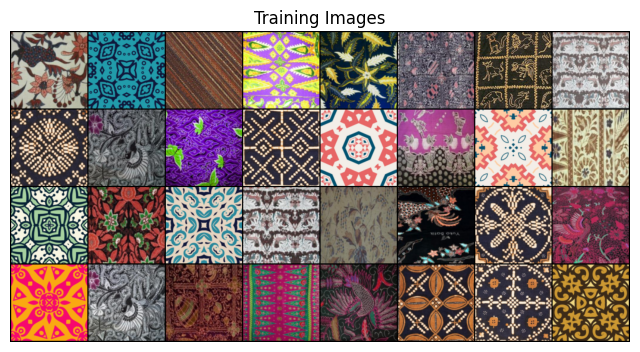

In [4]:
transform = transforms.Compose([
    transforms.Resize((RESOLUTION, RESOLUTION)),
    transforms.ToTensor(),
    transforms.Normalize([0.5] * 3, [0.5] * 3, inplace=True)
])

dataset = BatikGANDataset(DATASET_PATH, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

# Show sample images
real_batch = next(iter(dataloader))
images = real_batch[0] if isinstance(real_batch, (tuple, list)) else real_batch

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
grid = make_grid(images[:64], padding=2, normalize=True)
plt.imshow(np.transpose(grid.cpu(), (1, 2, 0)))
plt.show()

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(LATENT_DIM, ngf*16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*16),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*16, ngf*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, IMAGE_CHANNELS, 4, 2, 1, bias=False),
            nn.Tanh()
        )


    def forward(self, input):
        return self.main(input)

In [7]:
gen = Generator().to(DEVICE)
gen.apply(weights_init)
print(gen)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(512, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchN

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(IMAGE_CHANNELS, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 16, 1, 4, 1, 0, bias=False),
            # nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [9]:
disc = Discriminator().to(DEVICE)
disc.apply(weights_init)
print(disc)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(1024, eps=1e-05

In [10]:
criterion = nn.BCEWithLogitsLoss() 

optimizerD = optim.Adam(disc.parameters(), lr=1e-4, betas=(beta1, 0.999))
optimizerG = optim.Adam(gen.parameters(), lr=2e-4, betas=(beta1, 0.999))

fixed_noise = torch.randn(64, LATENT_DIM, 1, 1, device=DEVICE)

In [11]:
def save_checkpoint(generator, discriminator, optim_g, optim_d, epoch, folder="/kaggle/working/checkpoints"):
    os.makedirs(folder, exist_ok=True)

    checkpoint = {
        'generator': generator.state_dict(),
        'discriminator': discriminator.state_dict(),
        'optim_g': optim_g.state_dict(),
        'optim_d': optim_d.state_dict(),
        'epoch': epoch,
    }

    filename = f"{folder}/checkpoint_epoch{epoch}.pt"
    torch.save(checkpoint, filename)
    print(f"Saved checkpoint: {filename}")

In [ ]:
SAVE_DIR = '/kaggle/working/results'
os.makedirs(SAVE_DIR, exist_ok=True)

gen_losses = []
disc_losses = []

print("Starting Training Loop...")
for epoch in range(EPOCHS):
    for i, data in enumerate(dataloader, 0):

        # Discriminator
        real_images = data.to(DEVICE)

        b_size = real_images.size(0)
        noise = torch.randn(b_size, LATENT_DIM, 1, 1, device=DEVICE)
        fake_images = gen(noise)

        disc_real = disc(real_images).reshape(-1)
        loss_real = criterion(disc_real, torch.full_like(disc_real, 0.9))

        disc_fake = disc(fake_images.detach()).reshape(-1)
        loss_fake = criterion(disc_fake, torch.zeros_like(disc_fake))

        loss_disc = (loss_real + loss_fake) / 2

        optimizerD.zero_grad()
        loss_disc.backward()
        optimizerD.step()

        # Generator
        output = disc(fake_images).reshape(-1)

        loss_gen = criterion(output, torch.ones_like(output))

        optimizerG.zero_grad()
        loss_gen.backward()
        optimizerG.step()

        # logging
        if i % 50 == 0:
            print(f"[Epoch {epoch}/{EPOCHS}] [Batch {i}/{len(dataloader)}] "
                  f"[D loss: {loss_disc.item():.4f}] [G loss: {loss_gen.item():.4f}]")

    gen_losses.append(loss_gen.item())
    disc_losses.append(loss_disc.item())

    # save images every 5 epochs and checkpoints every 10 epochs
    if (epoch + 1) % 5 == 0 or (epoch + 1) == EPOCHS:
        with torch.no_grad():
            fake = gen(fixed_noise).detach().cpu()
        save_image(fake, os.path.join(SAVE_DIR, f"epoch{epoch+1}.png"), normalize=True, nrow=8)

    if (epoch + 1) % 10 == 0 or (epoch + 1) == EPOCHS:
        save_checkpoint(gen, disc, optimizerG, optimizerD, epoch + 1)

In [ ]:
!pip install onnx

In [14]:
import onnx

gen.eval()

z = torch.randn(1, LATENT_DIM, 1, 1, device=DEVICE)
torch.onnx.export(
    gen,
    z,
    'generator.onnx',
    input_names=['z'],
    output_names=['output'],
    dynamic_axes={
        'z': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    },

)

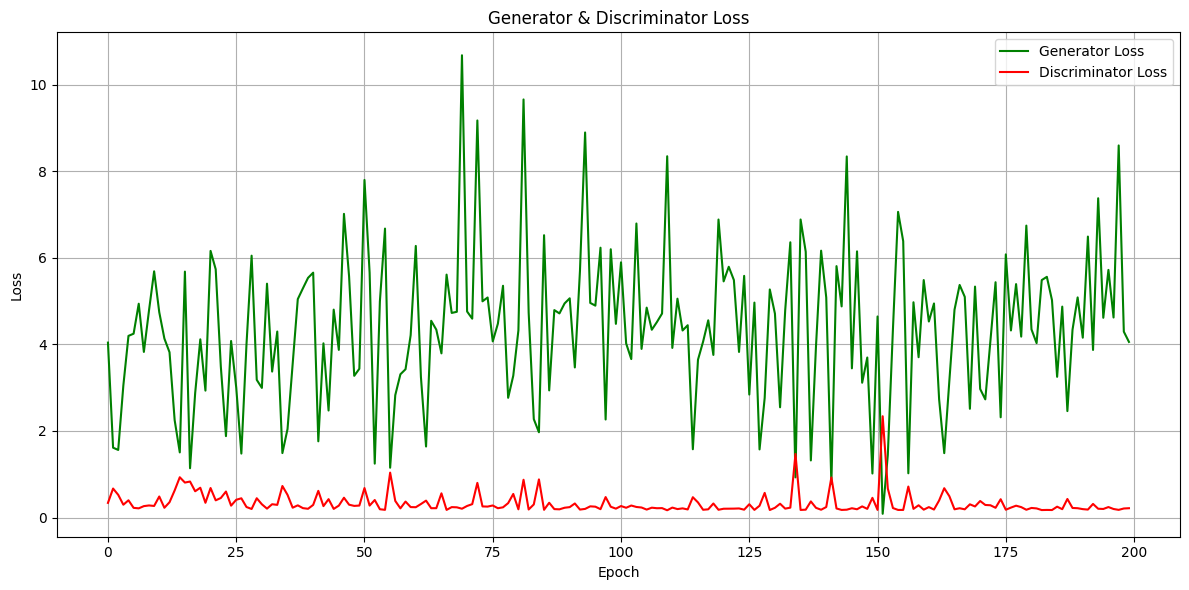

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(gen_losses, label="Generator Loss", color="green")
plt.plot(disc_losses, label="Discriminator Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Generator & Discriminator Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"loss.png")
plt.show()